In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import GridSearchCV


In [3]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

In [4]:
train_df = train_df.drop('Unnamed: 0',axis = 1)
test_df = test_df.drop('Unnamed: 0',axis = 1)

In [5]:
train_df_encoded = pd.get_dummies(train_df, columns=['language',	'emotion',	'gender'])
test_df_encoded = pd.get_dummies(test_df, columns=['language',	'emotion',	'gender'])


In [6]:
columns = [column for column in train_df_encoded.columns if 'file_name' != column and 'duration' != column and 'emotion_' not in column ]
pred_column = 'emotion_SAD'


Logistic Regression

In [9]:
scorer = make_scorer(average_precision_score, needs_proba=True)

# Define the model
model = XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'colsample_bytree': [0.9, 0.95, 1.0],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scorer, verbose=5)


/Users/danny/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [10]:
grid_search.fit(train_df_encoded[columns], train_df_encoded[pred_column])


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4;, score=0.958 total time=   4.4s
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4;, score=0.964 total time=   5.0s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4;, score=0.963 total time=   4.9s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4;, score=0.971 total time=   5.3s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4;, score=0.974 total time=   4.8s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6;, score=0.959 total time=   8.5s
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6;, score=0.961 total time=   7.4s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6;, score=0.964 total time=   7.4s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6;, score=0.967 total time=   8.0s
[CV 5/5] END colsample_bytree=0.9, lea

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.9, 0.95, 1.0],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [4, 6, 8]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=5)

In [11]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4}
Best cross-validation score: 0.97


In [12]:
best_model = grid_search.best_estimator_


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict test data
y_pred = best_model.predict(test_df_encoded[columns])

# Evaluate the model
print("Test Accuracy:", accuracy_score(test_df_encoded[pred_column], y_pred))
print("Classification Report:\n", classification_report(test_df_encoded[pred_column], y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_df_encoded[pred_column], y_pred))

Test Accuracy: 0.9959514170040485
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       167
           1       1.00      0.99      0.99        80

    accuracy                           1.00       247
   macro avg       1.00      0.99      1.00       247
weighted avg       1.00      1.00      1.00       247

Confusion Matrix:
 [[167   0]
 [  1  79]]


In [14]:
y_pred_prob = best_model.predict_proba(test_df_encoded[columns])

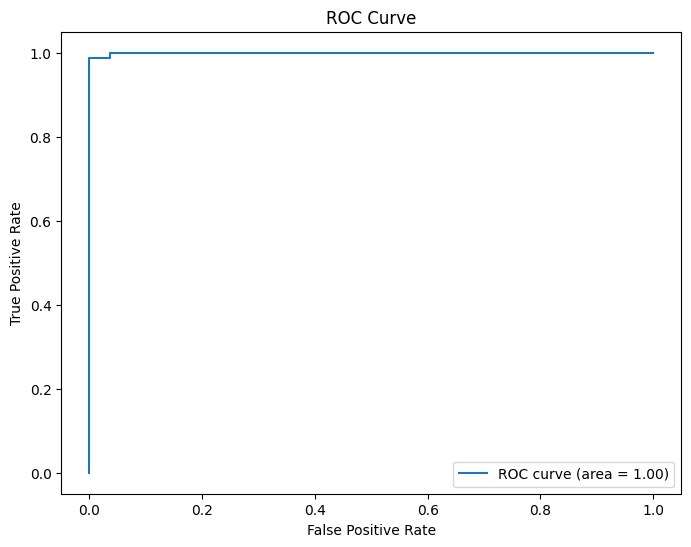

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_df_encoded[pred_column], y_pred_prob[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(test_df_encoded[pred_column], y_pred_prob[:, 1]):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [18]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(best_model, train_df_encoded[columns])

# Calculate SHAP values for the test set
shap_values = explainer(test_df_encoded[columns])

/Users/danny/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


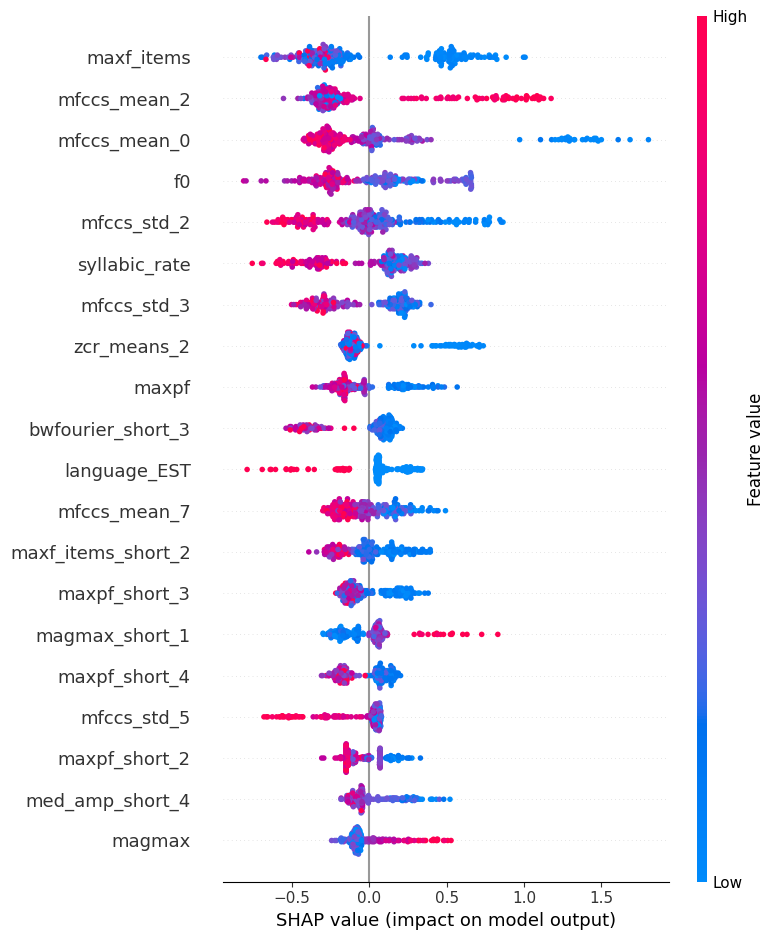

In [19]:
shap.summary_plot(shap_values, test_df_encoded[columns], feature_names=columns)


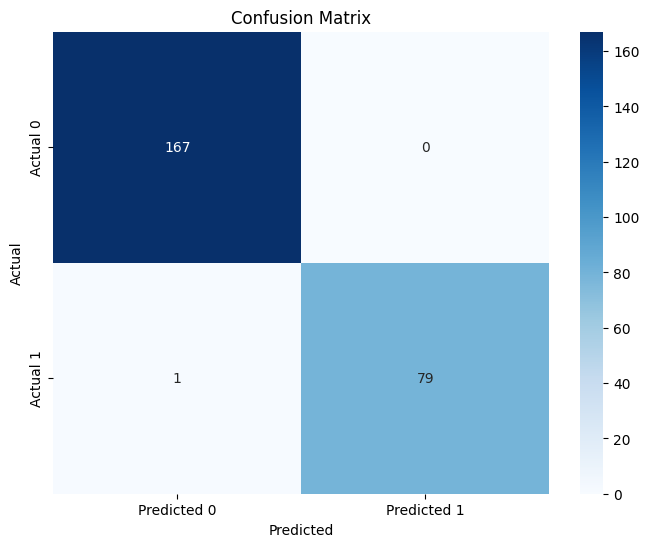

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined
cm = confusion_matrix(test_df_encoded[pred_column], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()